# Aim of this document is to create a model of the FWt with Gravity acting as an external force and linerise the EoM about all ifxed points (across velocities)

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the problem

In [2]:
# create instance of a simplified model parameters
p = dof2.Simplified2DofModel(inner_freq=2,inner_mass=4,mass_ratio=4)
p.g.value = 9.81

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2 # + p.m*p.g*(-p.l*sym.sin(p.q[0]))

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([p.q[0],0,0])

mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)
M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)
m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)

# External Forces
AeroForces = ams.AeroModelv1(p,fwt_frame,at_mode=1)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce([GravityForces,AeroForces])

# create instance of the model
sM = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)

p.Lambda.value = np.deg2rad(25)

### Determine the fixed points of this system

In [3]:
#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,50,201)
aoa = [0,5,10]
lambdas = [10,25]

df = pd.DataFrame(columns=['v','aoa','Lambda','eta','q1'])

def ToMinimise(x):
    val = sM.deriv(0,[x[0],0,x[1],0],p)
    return val[1]**2 + val[3]**2
    
for lam in lambdas:
    p.Lambda.value = np.deg2rad(lam)
    for i in aoa:
        p.alpha_r.value = np.deg2rad(i)    
        guess = [np.pi/2,0]
        for v in vs:
            p.V.value = v
            guess = minimize(ToMinimise,guess).x
            df = df.append({'aoa' : i, 'v' : v,'Lambda':lam,'eta':guess[0],'q1':guess[1]} , ignore_index=True)

df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])

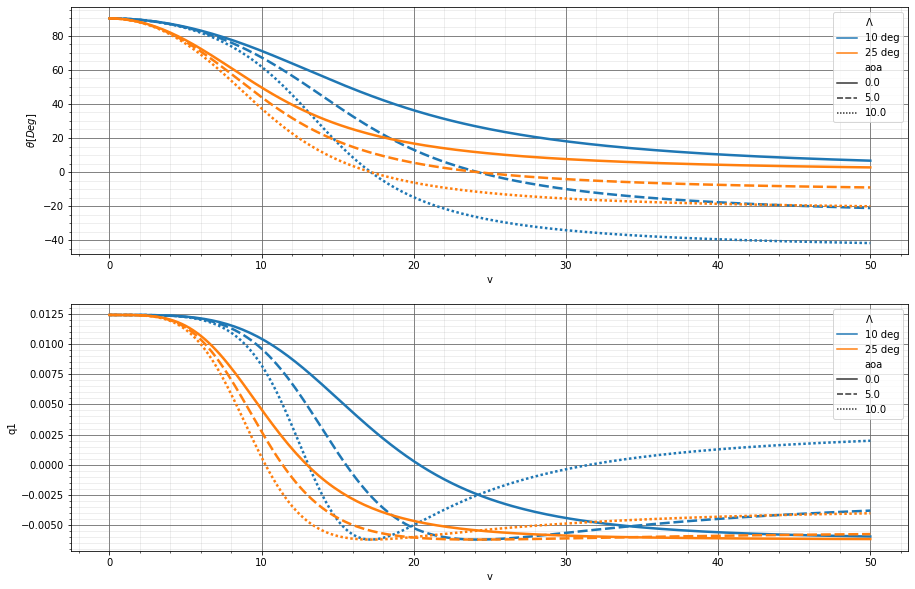

In [34]:
# plot the data
fig, axes = plt.subplots(2,1,figsize=(15,10))
df[r'$\theta [Deg]$']= np.rad2deg(df['eta'])
df[r'$\Lambda$'] = df.apply(lambda row: f'{row.Lambda:.0f} deg',axis=1)
sns.lineplot(data=df,y=r'$\theta [Deg]$',x='v',style='aoa',hue=r'$\Lambda$',ax=axes[0],linewidth=2.5)

sns.lineplot(data=df,y='q1',x='v',style='aoa',hue=r'$\Lambda$',ax=axes[1],linewidth=2.5)

for ax in axes:
    #ax.set(xlim=(0,80))
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Linearise the system about some fixed points

In [20]:
# create complete EoM
func = dof2.LinearEoM_func(sM,p,ignore=[p.V,p.Lambda,p.alpha_r])

In [21]:
data = df

flutdfv2 = pd.DataFrame()
    
for i in range(0,len(data)):  
    # get the fixed point
    aoa = data['aoa'].iloc[i]
    lam = data['Lambda'].iloc[i]
    lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]
    # get the jacobian evaluated at this point
    j_lp = func(data['v'].iloc[i],np.deg2rad(lam),np.deg2rad(aoa),lp)
    # get eigen value information
    jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    # populate test specific data   
    jac_dat['V'] = data['v'].iloc[i]
    jac_dat['aoa'] = aoa
    jac_dat['lp'] = [lp for i in range(0,len(jac_dat))]
    jac_dat[r'$\Lambda$'] = data[r'$\Lambda$'].iloc[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,V,aoa,lp,$\Lambda$
0,-0.000000+3.836013j,-2.081668e-16,3.836013,0.610520,-1.608123e-16,True,"[(4.547849653108115e-17+0.25225676983071654j),...",0,0.00,0.0,"[1.5707963267554577, 0, 0.012424503138314773, 0]",10 deg
1,0.000000+12.566371j,4.440892e-16,12.566371,2.000000,6.123234e-17,True,[(3.160499441550117e-27+5.175076776799072e-12j...,1,0.00,0.0,"[1.5707963267554577, 0, 0.012424503138314773, 0]",10 deg
2,-0.018040+3.835984j,-1.803961e-02,3.835984,0.610523,-4.702683e-03,True,"[(-0.001186279916728874-0.2522531979521986j), ...",0,0.25,0.0,"[1.5705791223299896, 0, 0.01242450181410838, 0]",10 deg
3,-0.000000+12.566371j,-1.142135e-10,12.566371,2.000000,-9.088891e-12,True,[(1.886741260148086e-08+2.8501078071668014e-05...,1,0.25,0.0,"[1.5705791223299896, 0, 0.01242450181410838, 0]",10 deg
4,-0.036079+3.835895j,-3.607923e-02,3.835895,0.610529,-9.405271e-03,True,"[(-0.0023725135905515874-0.2522424510428279j),...",0,0.50,0.0,"[1.5699275483021864, 0, 0.01242448864639681, 0]",10 deg
...,...,...,...,...,...,...,...,...,...,...,...,...
2407,1.607344+13.825212j,1.607344e+00,13.825212,2.215172,1.154839e-01,False,"[(0.007197059410493707-0.0619039070094168j), (...",1,49.50,10.0,"[-0.34823497749738425, 0, -0.00404213727536979...",25 deg
2408,-5.740397+16.246463j,-5.740397e+00,16.246463,2.742364,-3.331479e-01,False,"[(-0.01891155539882979-0.053523458681970656j),...",0,49.75,10.0,"[-0.3486773044734975, 0, -0.004036846237514694...",25 deg
2409,1.602247+13.841208j,1.602247e+00,13.841208,2.217607,1.149913e-01,False,"[(0.007143715326744944-0.061711866419406645j),...",1,49.75,10.0,"[-0.3486773044734975, 0, -0.004036846237514694...",25 deg
2410,-5.755699+16.314028j,-5.755699e+00,16.314028,2.753314,-3.327074e-01,False,"[(-0.018811936505829054-0.05332079868329198j),...",0,50.00,10.0,"[-0.3491128754988796, 0, -0.004031630552544889...",25 deg


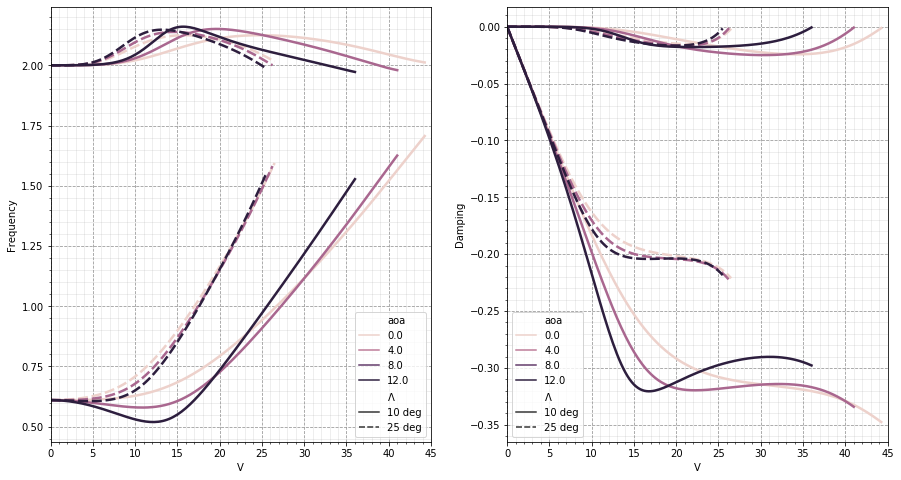

In [36]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,8))



sns.lineplot(data=data[data['Mode']==0],x='V',y='Frequency',hue='aoa',style=r'$\Lambda$',ax=axes[0],linewidth=2.5)
#axes[0].get_legend().remove()
sns.lineplot(data=data[data['Mode']==1],x='V',y='Frequency',hue='aoa',style=r'$\Lambda$',ax=axes[0],legend=False,linewidth=2.5)

sns.lineplot(data=data[data['Mode']==0],x='V',y='Damping',hue='aoa',style=r'$\Lambda$',ax=axes[1],linewidth=2.5)
#axes[1].get_legend().remove()
sns.lineplot(data=data[data['Mode']==1],x='V',y='Damping',hue='aoa',style=r'$\Lambda$',ax=axes[1],legend=False,linewidth=2.5)


#sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0],s=15,edgecolor = 'none')
#sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1],s=15,edgecolor = 'none')
for i in [0,1]:
    axes[i].set(xlim=(0,45))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [33]:
# get info for the first unstable point for each AoA

aoas = data['aoa'].unique()
idx = []

data = flutdfv2[~flutdfv2['Stable']]
for i in data['aoa'].unique():
    idx.append(data[data['aoa']==i].sort_values(by=['V'],axis=0).head(1).index[0])
    
res = flutdfv2.iloc[idx].copy()
res['eta'] = res.apply(lambda row: np.rad2deg(row.lp[0]),axis=1)
res[['aoa','V','eta']]

,aoa,V,eta
214,0.0,26.75,9.561331
616,2.5,26.75,3.739337
1016,5.0,26.50,-1.959260
1416,7.5,26.25,-7.595315
1814,10.0,25.75,-12.872695
